In [79]:
import pandas as pd
import scipy as sc
import numpy as np
import re
import math
import seaborn as sns
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [3]:
astro1 = pd.read_csv('split_astro_ds_1.csv', low_memory = False)
astro2 = pd.read_csv('split_astro_ds_2.csv', low_memory = False)

# L X W X H

astro2.columns = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'n_obs_used', 'H',
       'diameter', 'extent', 'albedo', 'rot_per']
astro2['GM'] = pd.NA
astro2['BV'] = pd.NA
astro2['UB'] = pd.NA
astro2['IR'] = pd.NA
astro2['spec_B'] = pd.NA
astro2['spec_T'] = pd.NA
astro = pd.concat([astro1, astro2])

In [4]:
astro.drop('n_obs_used', axis = 1)
astrotrain = astro.drop(['spec_B', 'spec_T', 'BV', 'UB', 'IR', 'extent', 'GM', 'rot_per'], axis = 1)
astrotrain = astrotrain.dropna()
print(astrotrain)

            a       e      i      om       w      q    ad  per_y  n_obs_used  \
0       2.767  0.0788  10.59   80.26   73.47  2.549  2.99   4.60        1075   
1       2.770  0.2301  34.93  172.92  310.86  2.132  3.41   4.61        9049   
2       2.670  0.2565  12.99  169.84  247.74  1.985  3.35   4.36        7445   
3       2.363  0.0888   7.14  103.76  151.60  2.153  2.57   3.63        9451   
4       2.579  0.1879   5.36  141.52  358.89  2.094  3.06   4.14        3454   
...       ...     ...    ...     ...     ...    ...   ...    ...         ...   
439782  3.142  0.0809  14.75  303.10   20.16  2.888  3.40   5.57         155   
439822  3.197  0.2532  12.33  205.44   54.09  2.387  4.01   5.72         187   
439952  2.303  0.1981  23.54  326.93   34.29  1.847  2.76   3.50          78   
439963  3.064  0.1798  15.17  320.11  290.17  2.513  3.62   5.36          66   
439968  2.352  0.2574   3.39  264.99   57.78  1.747  2.96   3.61         133   

            H  diameter  albedo  
0    

Variance ratio array: [3.45068075e-01 1.99264189e-01 1.12824730e-01 9.22577744e-02
 7.61329767e-02 7.34837910e-02 6.54206793e-02 3.06307437e-02
 4.04659873e-03 6.40966655e-04 2.28887009e-04 5.88232747e-07]


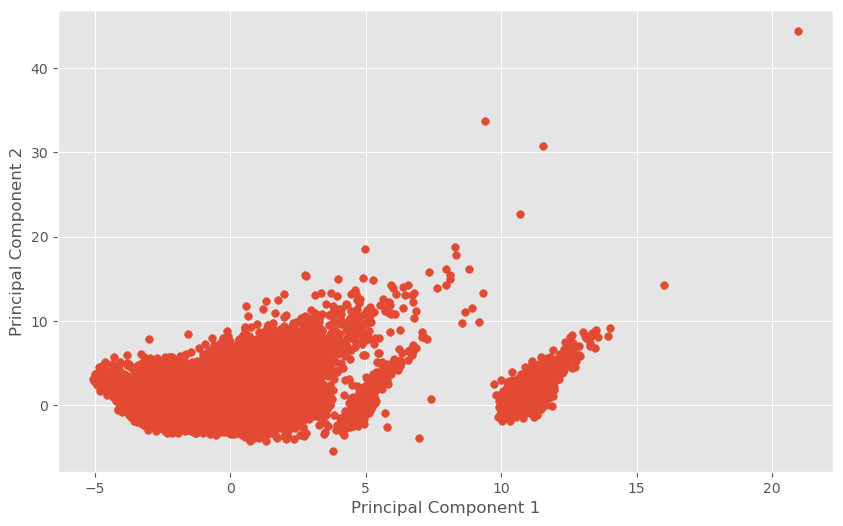

In [5]:
astro_scale = scale(astrotrain)
pca_model = PCA()
X_PCA = pca_model.fit_transform(astro_scale)

var_ratio = pca_model.explained_variance_ratio_
print(f"Variance ratio array: {var_ratio}")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.scatter(X_PCA[:, 0], X_PCA[:, 1], s=30)
plt.show()

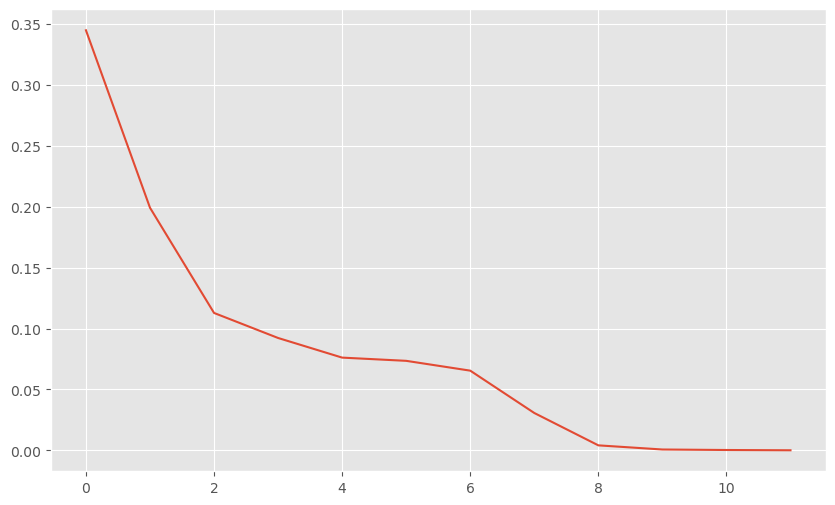

In [6]:
plt.plot(var_ratio)

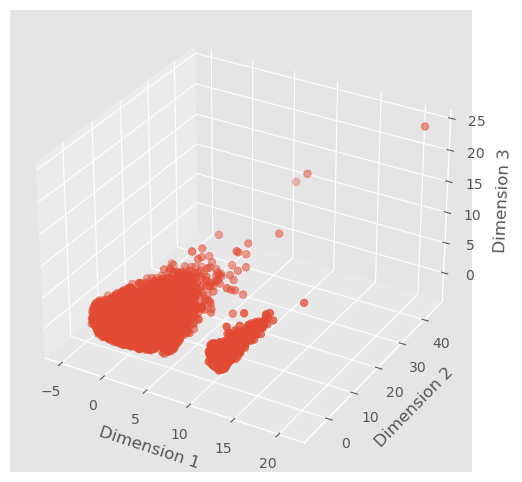

In [7]:
# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_PCA[:, 0], X_PCA[:, 1],zs= X_PCA[:, 2], s=30)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()

In [8]:
# now cutting down to what we already know
astro_group = astro1.drop(['n_obs_used', 'extent', 'rot_per'], axis = 1)
print(len(astro_group))

astro_group['IsUseful'] = np.nan

astro_group = astro_group.dropna(subset=['spec_T', 'spec_B'], how='all')
astro_group.reset_index(drop=True, inplace=True)

for i in range(len(astro_group)):
    specB = astro_group['spec_B'][i]
    specT = astro_group['spec_T'][i]
    
    astro_group['IsUseful'][i] = 0
    if specT == "M" or specT == "R" or specT == "Q":
        astro_group['IsUseful'][i] = 1
    if (specB == "Sq" or specB == "Sr" or specB == "X" or specB == "Xc" or specB == "Xe"):
        astro_group['IsUseful'][i] = 1

            
print(astro_group)
print(astro_group['IsUseful'].value_counts())

608436


C:\Users\matts\AppData\Local\Temp\ipykernel_17224\2256516675.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  astro_group['IsUseful'][i] = 0
C:\Users\matts\AppData\Local\Temp\ipykernel_17224\2256516675.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  astro_group['IsUseful'][i] = 1
C:\Users\matts\AppData\Local\Temp\ipykernel_17224\2256516675.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  astro_group['IsUseful'][i] = 1


          a       e      i      om       w      q    ad  per_y      H  \
0     2.767  0.0788  10.59   80.26   73.47  2.549  2.99   4.60   3.33   
1     2.770  0.2301  34.93  172.92  310.86  2.132  3.41   4.61   4.12   
2     2.670  0.2565  12.99  169.84  247.74  1.985  3.35   4.36   5.15   
3     2.363  0.0888   7.14  103.76  151.60  2.153  2.57   3.63   3.22   
4     2.579  0.1879   5.36  141.52  358.89  2.094  3.06   4.14   7.00   
...     ...     ...    ...     ...     ...    ...   ...    ...    ...   
1737  2.238  0.1911   4.71  265.14   81.67  1.810  2.67   3.35  13.88   
1738  2.790  0.1747   8.66  337.97   39.11  2.302  3.28   4.66  14.01   
1739  1.969  0.0579  18.26  264.42  286.61  1.855  2.08   2.76  15.83   
1740  3.497  0.5336  21.35  129.43   43.63  1.631  5.36   6.54  16.04   
1741  3.575  0.6000   8.14   69.31   53.59  1.430  5.72   6.76  14.36   

      diameter  albedo         GM     BV     UB  IR spec_B spec_T  IsUseful  
0      939.400  0.0900  62.628400  0.713  0.4

0.0    1436
1.0     269
Name: IsUseful, dtype: int64
Variance ratio array: [3.70486917e-01 1.28260353e-01 1.05333370e-01 9.30264939e-02
 8.56878705e-02 7.43446695e-02 7.11738848e-02 5.45489552e-02
 1.62706972e-02 5.74623055e-04 2.91630352e-04 5.34881282e-07]


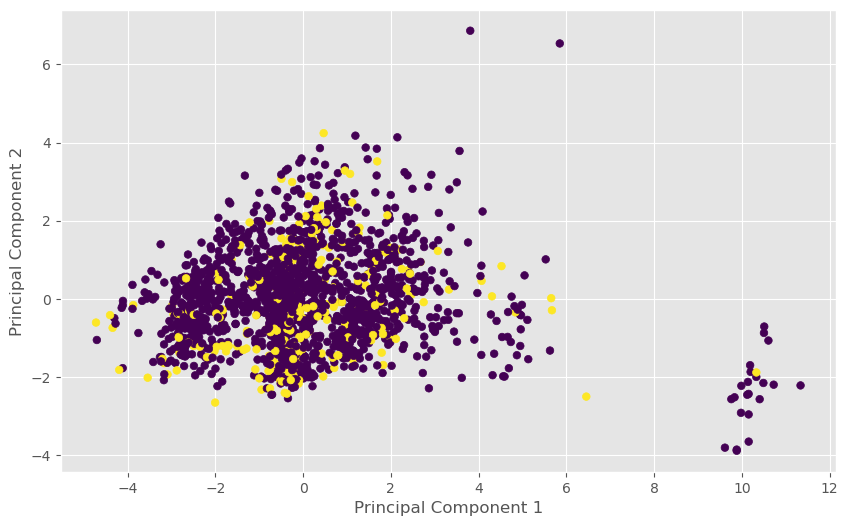

In [9]:
from pandas.plotting import scatter_matrix

astro_clear =astro_group.drop(['spec_B', 'spec_T', 'BV', 'UB', 'IR', 'GM'], axis = 1)
astro_clear = astro_clear.dropna()
print(astro_clear['IsUseful'].value_counts())

astrogroup_scale = scale(astro_clear)
pca_model = PCA()
G_PCA = pca_model.fit_transform(astrogroup_scale)

var_ratio = pca_model.explained_variance_ratio_
print(f"Variance ratio array: {var_ratio}")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

y_change = astro_clear['IsUseful']

plt.scatter(G_PCA[:, 0], G_PCA[:, 1], c=y_change, s=30)
plt.show()

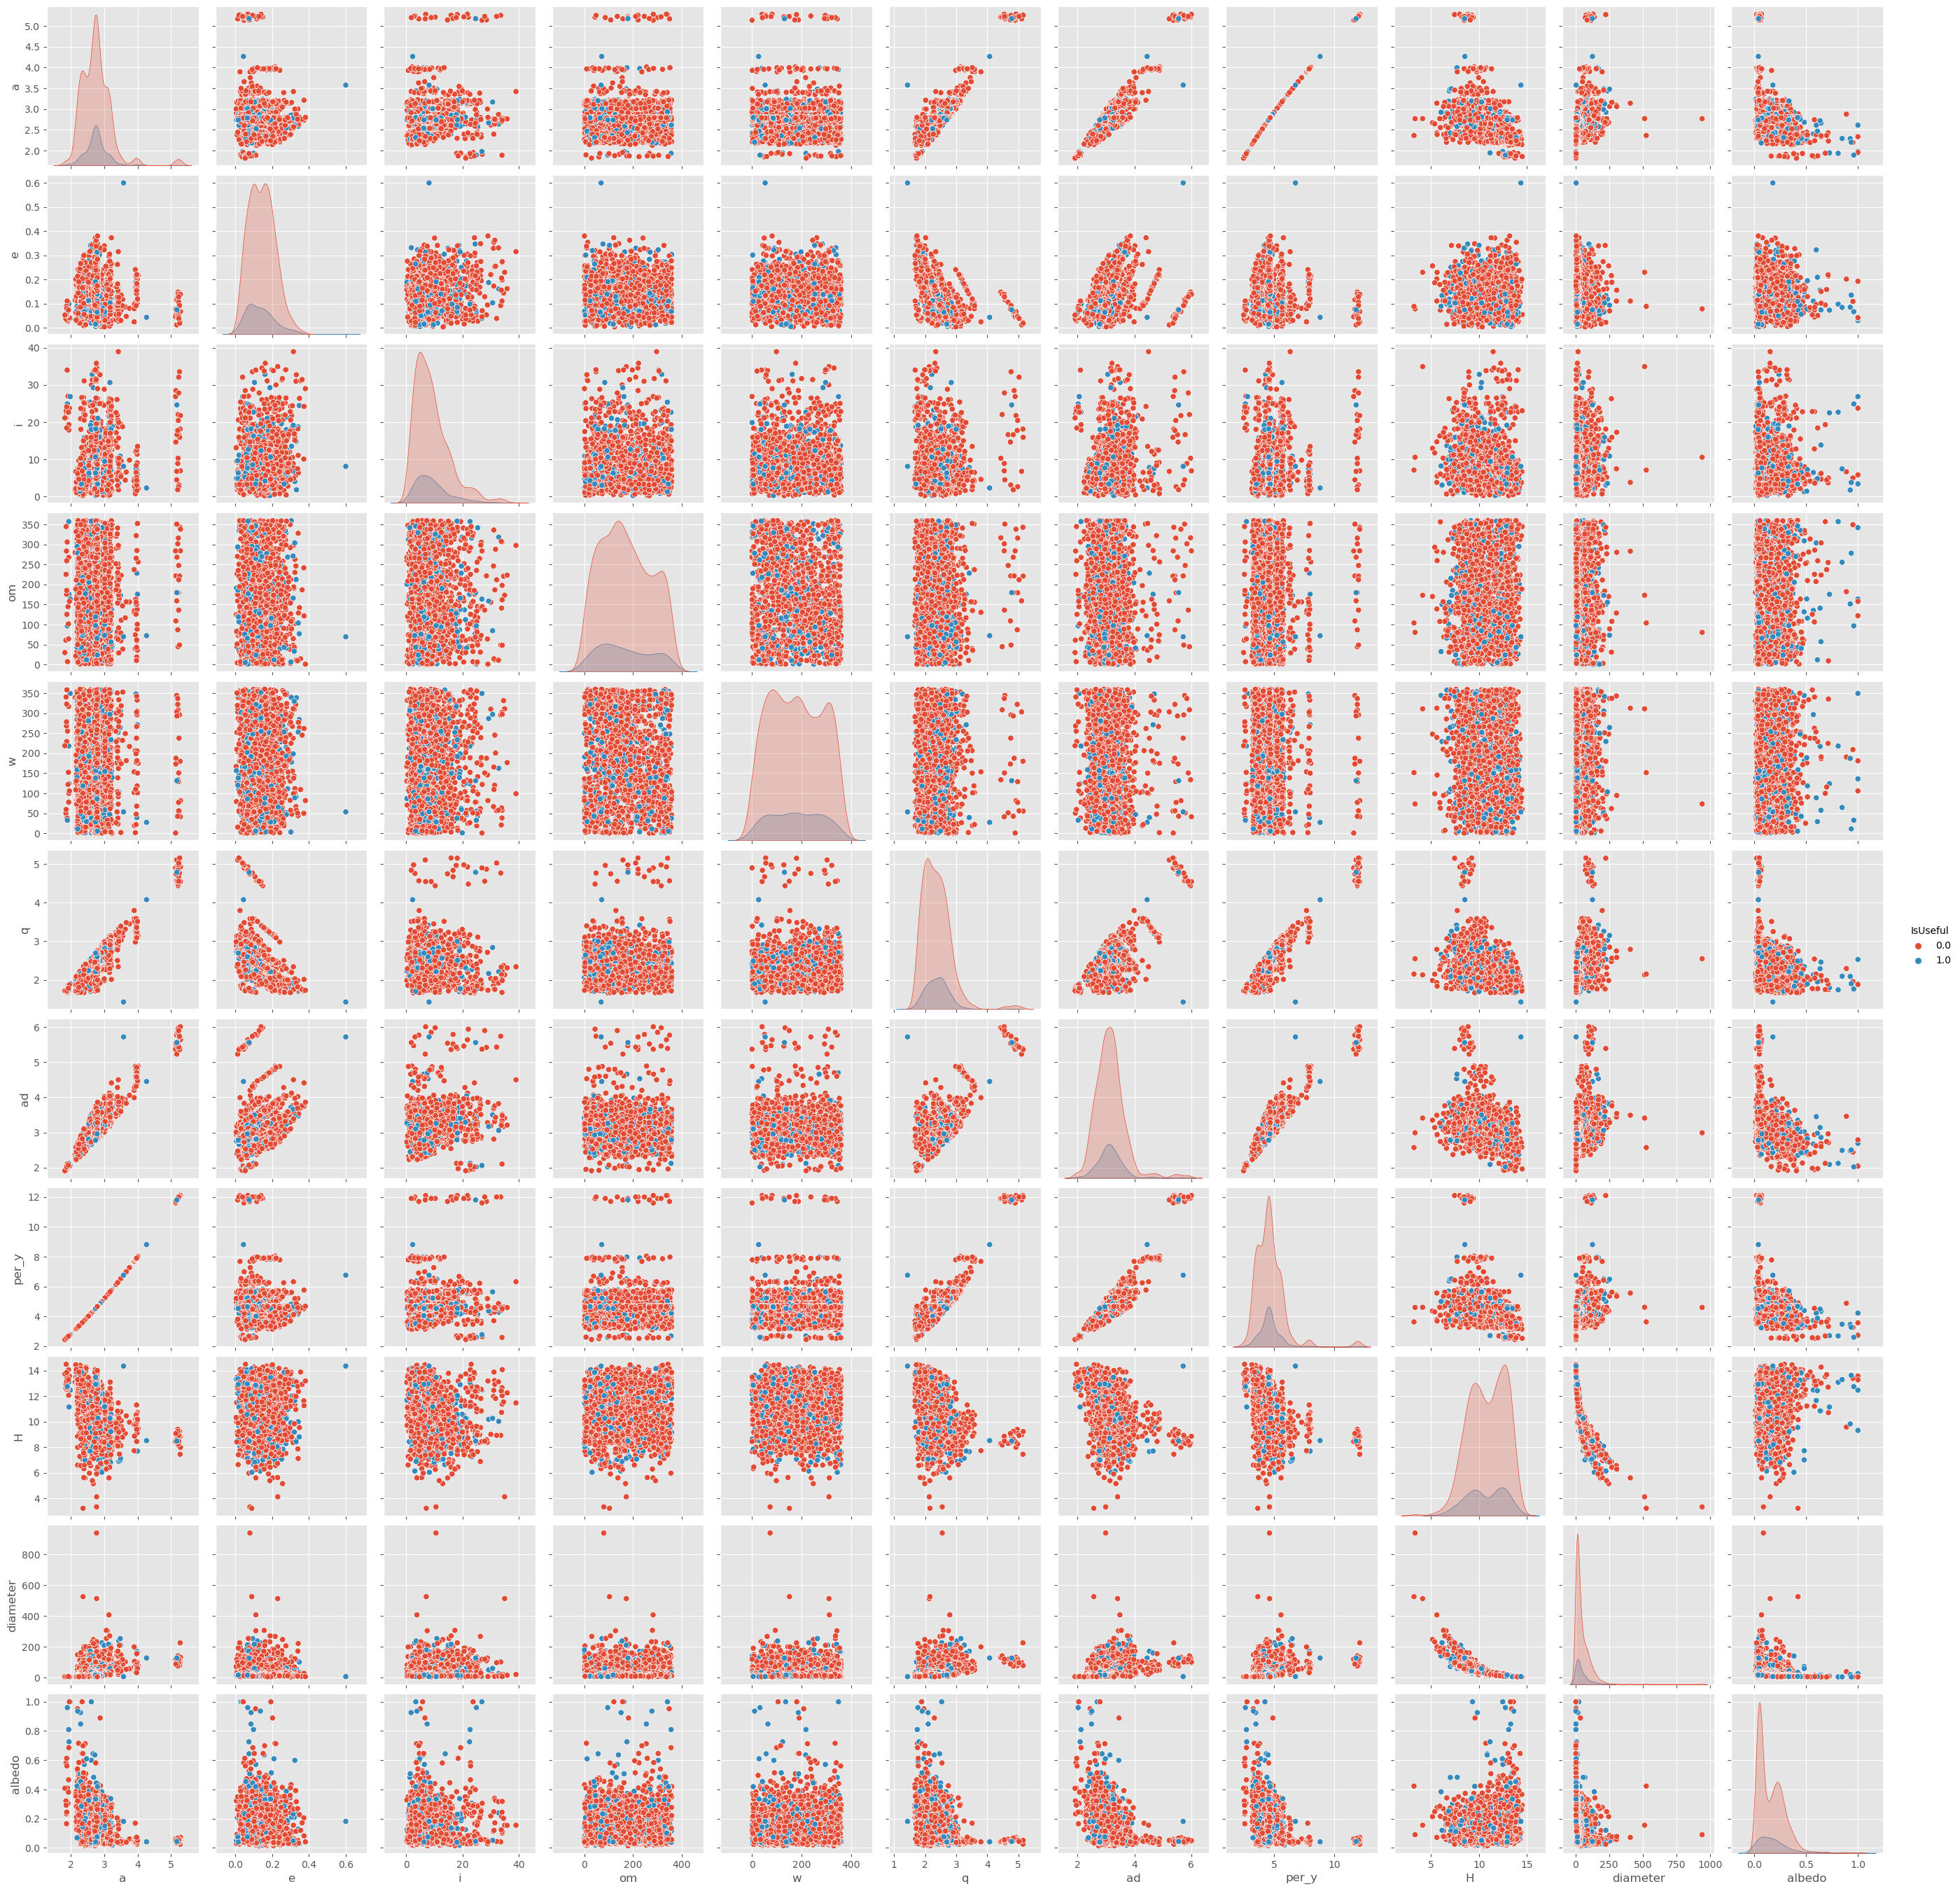

In [10]:
sns.pairplot(astro_clear, hue="IsUseful")

In [ ]:
"""
IDEAS:
1. use regex to read extent, get the volume and replace value
    a. Or use the extent to determine if it's more spherical or oblong
"""

In [75]:
# Creating regex function to classify if oblong or roughly spherical
# If oblong, use a cylinder formula
# if roughly spherical, use a sphere formula
# astro["extent"][3]
#astro.iat[3, 11]
test = astro.iat[3,11]
print(test)
match = re.search(r"([\d.]+)\s*x\s*([\d.]+)\s*x\s*([\d.]+)", astro.iat[3, 11])

extent_list = (match.groups())
int_list = []
for x in extent_list:
    int_list.append(float(x))
print(int_list)
#572.6 x 557.2 x 446.4
def get_volume(dims)
    if dims[0]

572.6 x 557.2 x 446.4
[572.6, 557.2, 446.4]


In [85]:
astro.head()

a       e      i      om       w      q    ad  per_y  n_obs_used     H  \
0  2.767  0.0788  10.59   80.26   73.47  2.549  2.99   4.60        1075  3.33   
1  2.770  0.2301  34.93  172.92  310.86  2.132  3.41   4.61        9049  4.12   
2  2.670  0.2565  12.99  169.84  247.74  1.985  3.35   4.36        7445  5.15   
3  2.363  0.0888   7.14  103.76  151.60  2.153  2.57   3.63        9451  3.22   
4  2.579  0.1879   5.36  141.52  358.89  2.094  3.06   4.14        3454  7.00   

   diameter                 extent  albedo    rot_per         GM     BV  \
0   939.400  964.4 x 964.2 x 891.8  0.0900   9.074170  62.628400  0.713   
1   513.000            568x532x448  0.1550   7.813221  13.630000  0.635   
2   246.596                    NaN  0.2140   7.210000        NaN  0.824   
3   525.400  572.6 x 557.2 x 446.4  0.4228   5.342128  17.288245  0.782   
4   106.699                    NaN  0.2740  16.806000        NaN  0.826   

      UB  IR spec_B spec_T  
0  0.426 NaN      C      G  
1  0.284 NaN      B      B  
2  0.433 NaN     Sk      S  
3  0.492 NaN      V      V  
4  0.411 NaN      S      S